### MLJAR AutoML starter

Use AutoML for finding fast solution and first model to test (I will see in model leaderboard to choose appropriate direction). The most interesting part for now is to find the first good model - which one is the most suitable for this competition. Certainly it could change (often it change) but ... good start is important.

The goal of this notebook is to explain how to build AutoML pipeline using MLJAR (explain arguments/parameters to build customized pipeline).

#### STEPS:

 - Create model Leaderboard using AutoML
 - Play with EDA and feature engeneering (I know this should be first step but ... we will do it later after first check)
 - One more time create leaderboard using AutoML - looking for improvements
 - Look for custom solutions based on learning from AutoML - we can use learnings from AutoML (just look inside AutoML logs :) - here you can find many tips)
 - Tuning (blending, mixing, optimizing ... etc.)
 
 MLJAR State-of-the-art Automated Machine Learning for tabular data. mljar builds a complete Machine Learning Pipeline
 
 - advanced feature engineering
 - algorithms selection and tuning
 - automatic documentation
 - ML explanations

##### Important links
 - MLJAR home
 - MLJAR GitHub

In [ ]:
!pip install pandas==1.2.0

In [ ]:
!pip install -q -U git+https://github.com/mljar/mljar-supervised.git@dev

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools

import seaborn as sns
sns.set(font_scale= 1.25)

from supervised.automl import AutoML # mljar-supervised

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


In [ ]:
train = pd.read_csv('/content/sample_data/train.csv', index_col = 'id')
test = pd.read_csv('/content/sample_data/test.csv', index_col = 'id')

In [ ]:
x_cols = train.columns[0:-1].tolist()
y_col = train.columns[-1]

**1. EDA - BEFORE WE START TRAINING MODEL - LET'S LOOK INTO DATA**

**TARGET DISTRIDUTION**

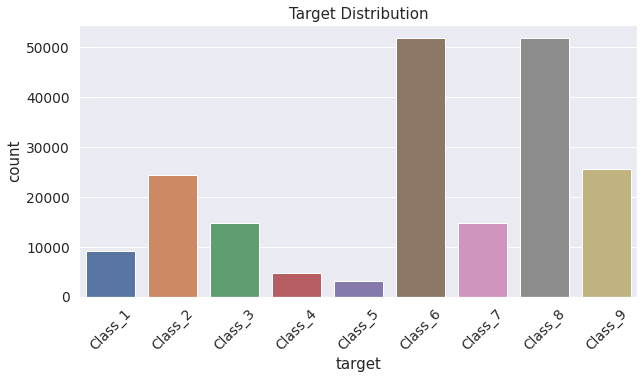

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))
plt.xticks(rotation=45)
ax = sns.countplot(x='target', data=train, order=sorted(train['target'].unique()), ax=ax)
ax.set_title('Target Distribution')
plt.show()

**TRAIN DATA**


In [ ]:
train.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

**TEST DATA**

In [ ]:
test.describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

**CROSS CHECK**

In [ ]:
# This snipplet was taken from great notebook: https://www.kaggle.com/subinium/tps-may-categorical-eda

def diff_color(x):
    color = 'red' if x<0 else ('green' if x > 0 else 'black')
    return f'color: {color}'

(train.describe() - test.describe())[test.columns].T.iloc[:,1:].style\
        .bar(subset=['mean', 'std'], align='mid', color=['#d65f5f', '#5fba7d'])\
        .applymap(diff_color, subset=['min', 'max'])

**FEATURE DISTRIBUTION - CLASS**

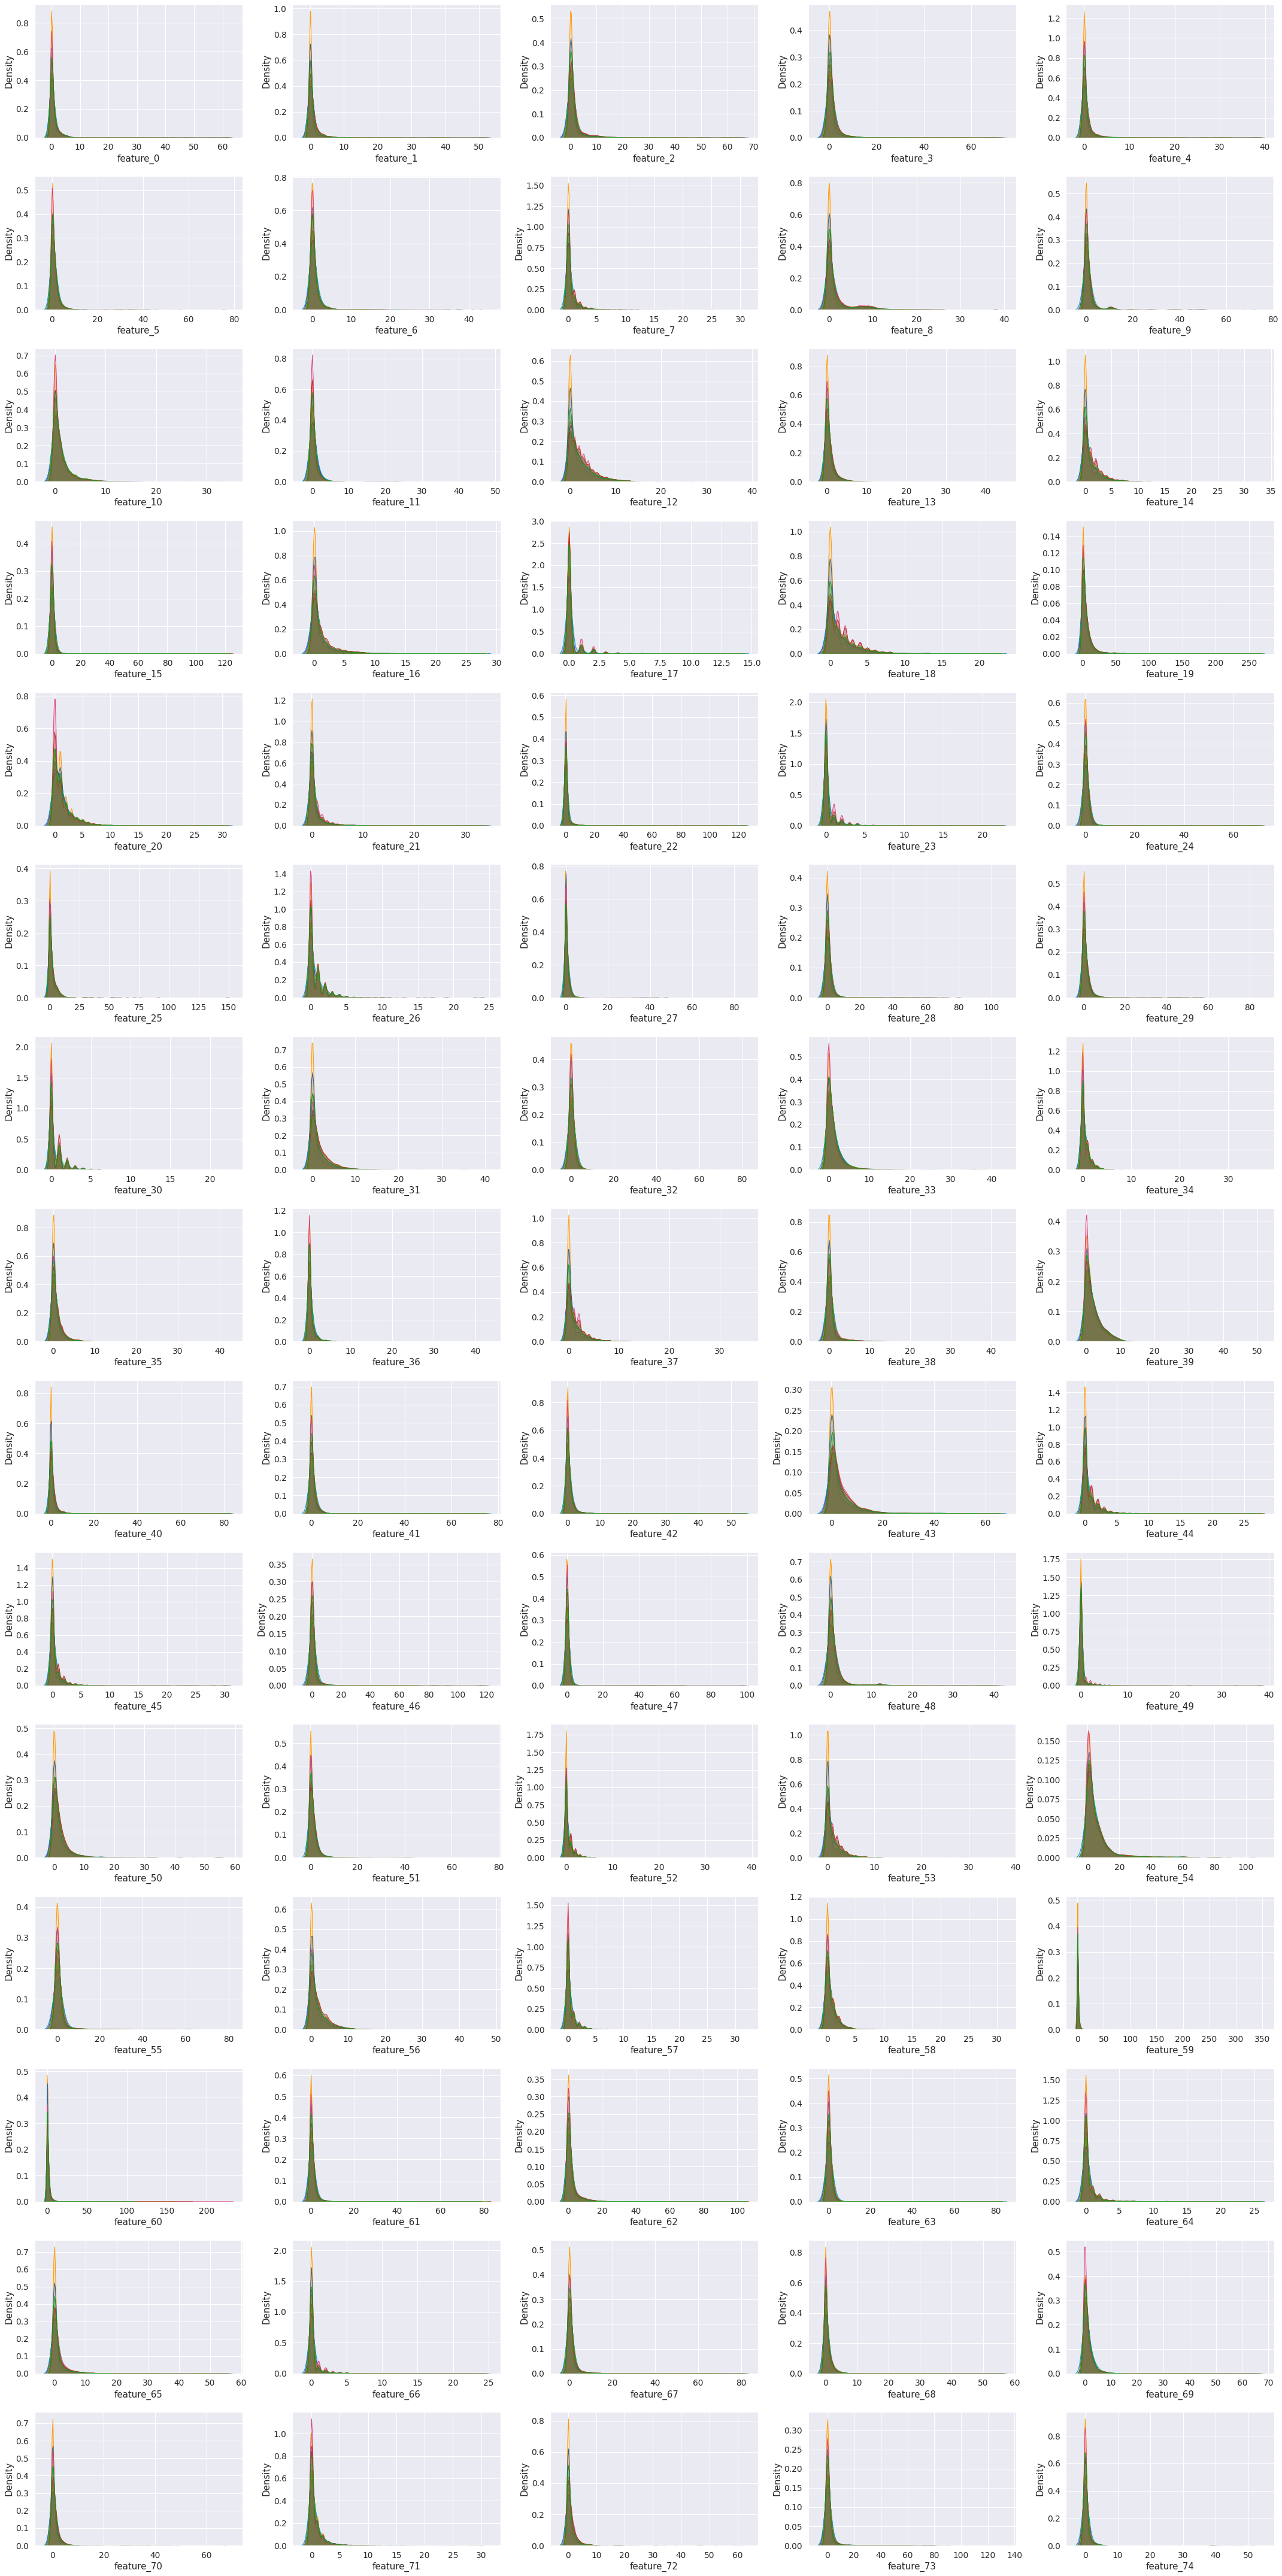

In [ ]:
import plotly.express as px

target_column = 'target'
num_rows, num_cols = 15,5
f, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(30, 60))

for index, column in enumerate(x_cols):
    i,j = (index // num_cols, index % num_cols)

    sns.kdeplot(train.loc[train[target_column] == 'Class_1', column], color=px.colors.qualitative.G10[1], shade=True, ax=axes[i,j])
    sns.kdeplot(train.loc[train[target_column] == 'Class_2', column], color=px.colors.qualitative.G10[2], shade=True, ax=axes[i,j])
    sns.kdeplot(train.loc[train[target_column] == 'Class_3', column], color=px.colors.qualitative.G10[9], shade=True, ax=axes[i,j])
    sns.kdeplot(train.loc[train[target_column] == 'Class_4', column], color=px.colors.qualitative.G10[4], shade=True, ax=axes[i,j])
    sns.kdeplot(train.loc[train[target_column] == 'Class_5', column], color=px.colors.qualitative.G10[5], shade=True, ax=axes[i,j])
    sns.kdeplot(train.loc[train[target_column] == 'Class_6', column], color=px.colors.qualitative.G10[6], shade=True, ax=axes[i,j])
    sns.kdeplot(train.loc[train[target_column] == 'Class_7', column], color=px.colors.qualitative.G10[7], shade=True, ax=axes[i,j])
    sns.kdeplot(train.loc[train[target_column] == 'Class_8', column], color=px.colors.qualitative.G10[8], shade=True, ax=axes[i,j])
    sns.kdeplot(train.loc[train[target_column] == 'Class_9', column], color=px.colors.qualitative.G10[3], shade=True, ax=axes[i,j])
plt.tight_layout()
plt.show()

**FEATURE DISTRIBUTION - TOTAL**

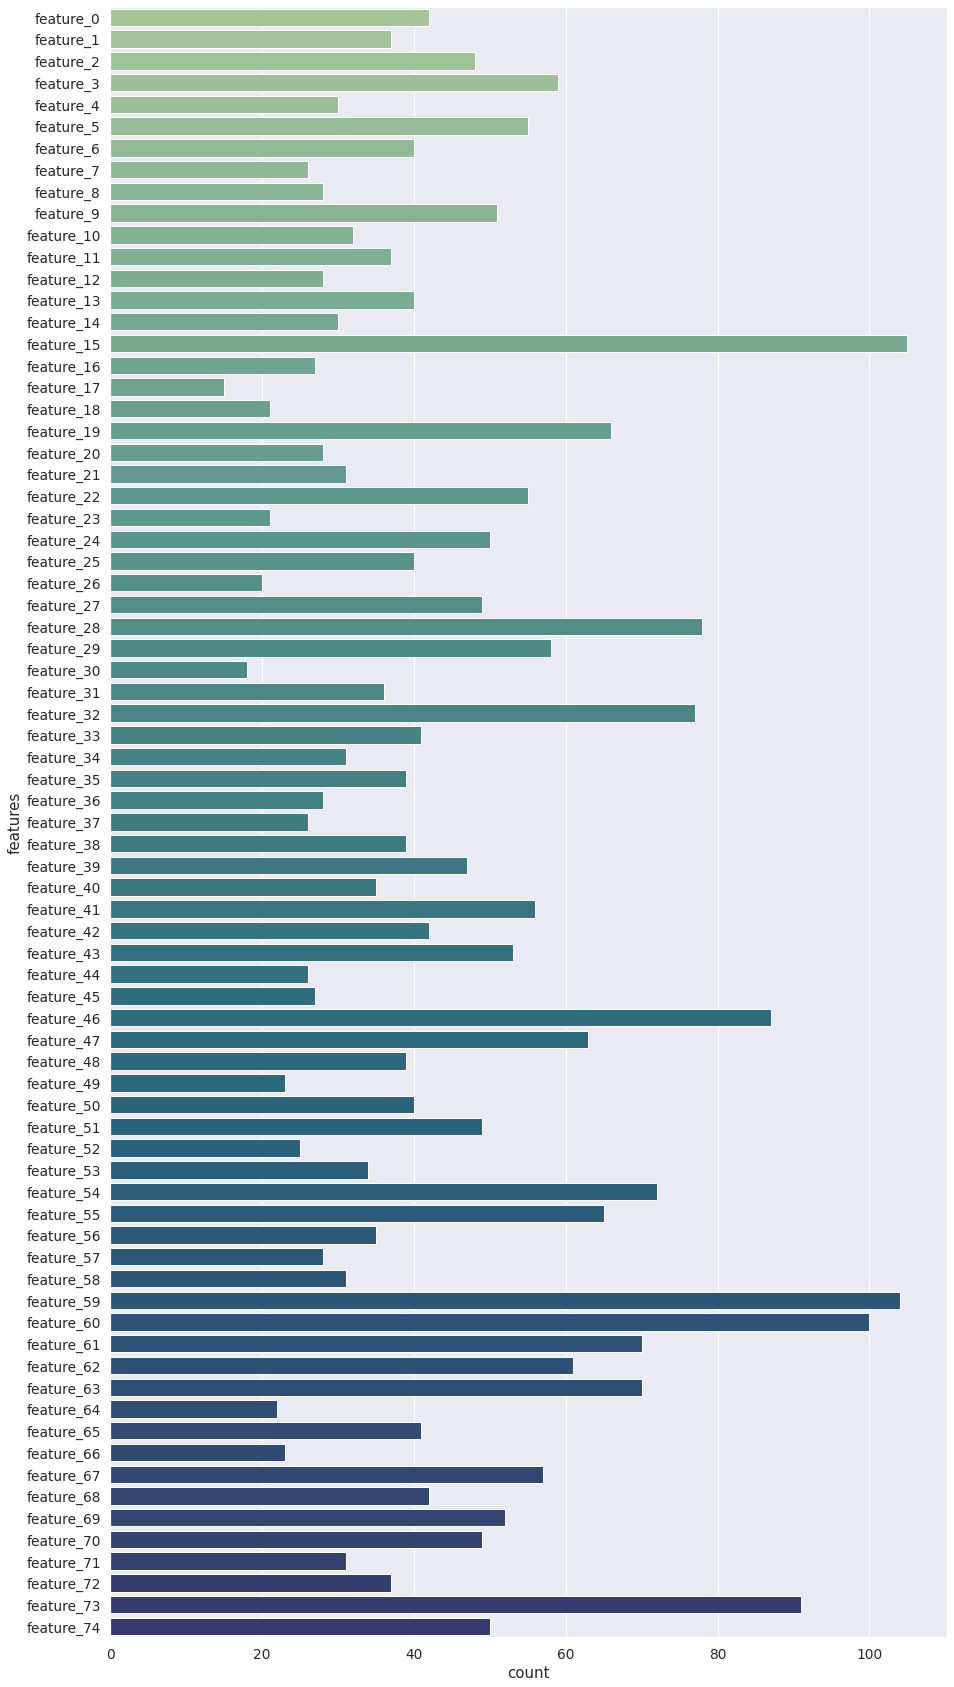

In [ ]:
df_all = pd.concat([train.drop('target', axis = 1), test], axis = 0)
unique_df = pd.DataFrame(df_all.nunique()).reset_index()
unique_df.columns=['features','count']


fig, feat_bar = plt.subplots(figsize = (15,30))
feat_bar = sns.barplot(y="features", x="count", data = unique_df, palette="crest", orient='h')

**ZEROS IN TRAIN**

Text(0.6564035333333337, 1, 'mean: 0.6464035333333337')

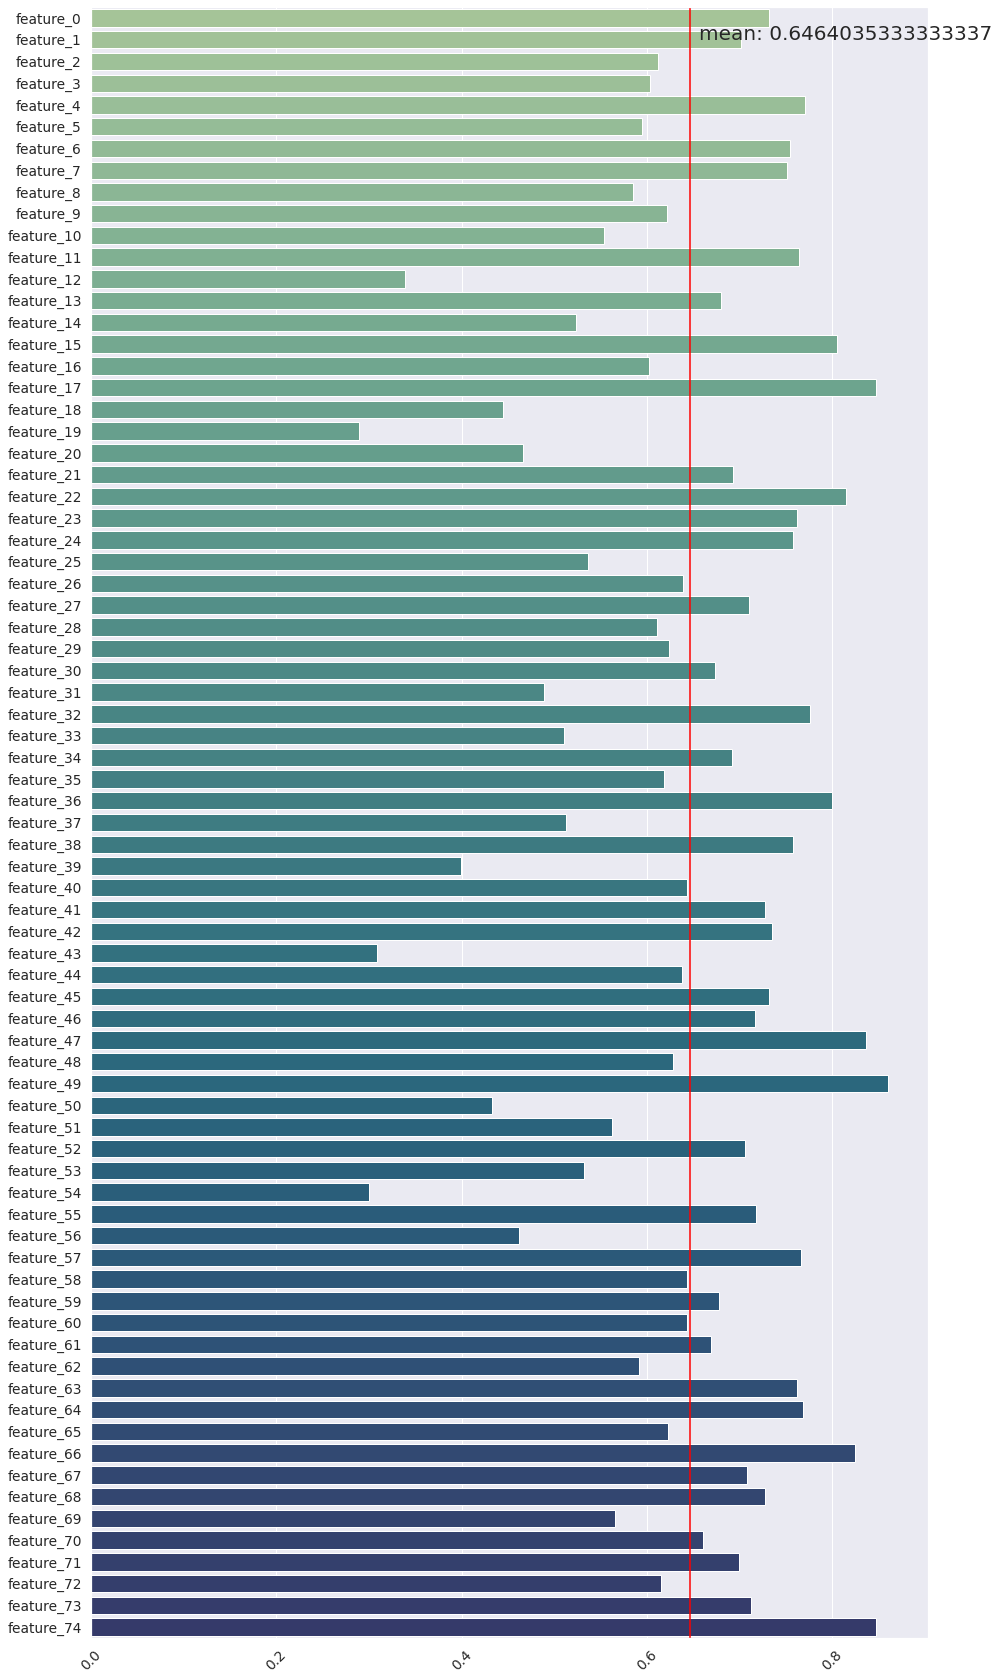

In [ ]:
fig, zero_train = plt.subplots(figsize = (15,30))
plt.xticks(rotation=45)
zero_train = sns.barplot(data = pd.DataFrame((train[x_cols]==0).mean()).T, palette="crest", orient='h')

zero_train.axvline((train[x_cols]==0).mean().mean(), color ='red')
zero_train.text((train[x_cols]==0).mean().mean()+0.01, 1, "mean: {}".format((train[x_cols]==0).mean().mean()), size = 20, alpha = 1)
#fig.suptitle('Zero distribution in TRAIN dataset', fontsize = 25, fontweight = 'bold')

**ZEROS IN TEST**

Text(0.6568955999999999, 1, 'mean: 0.6468955999999999')

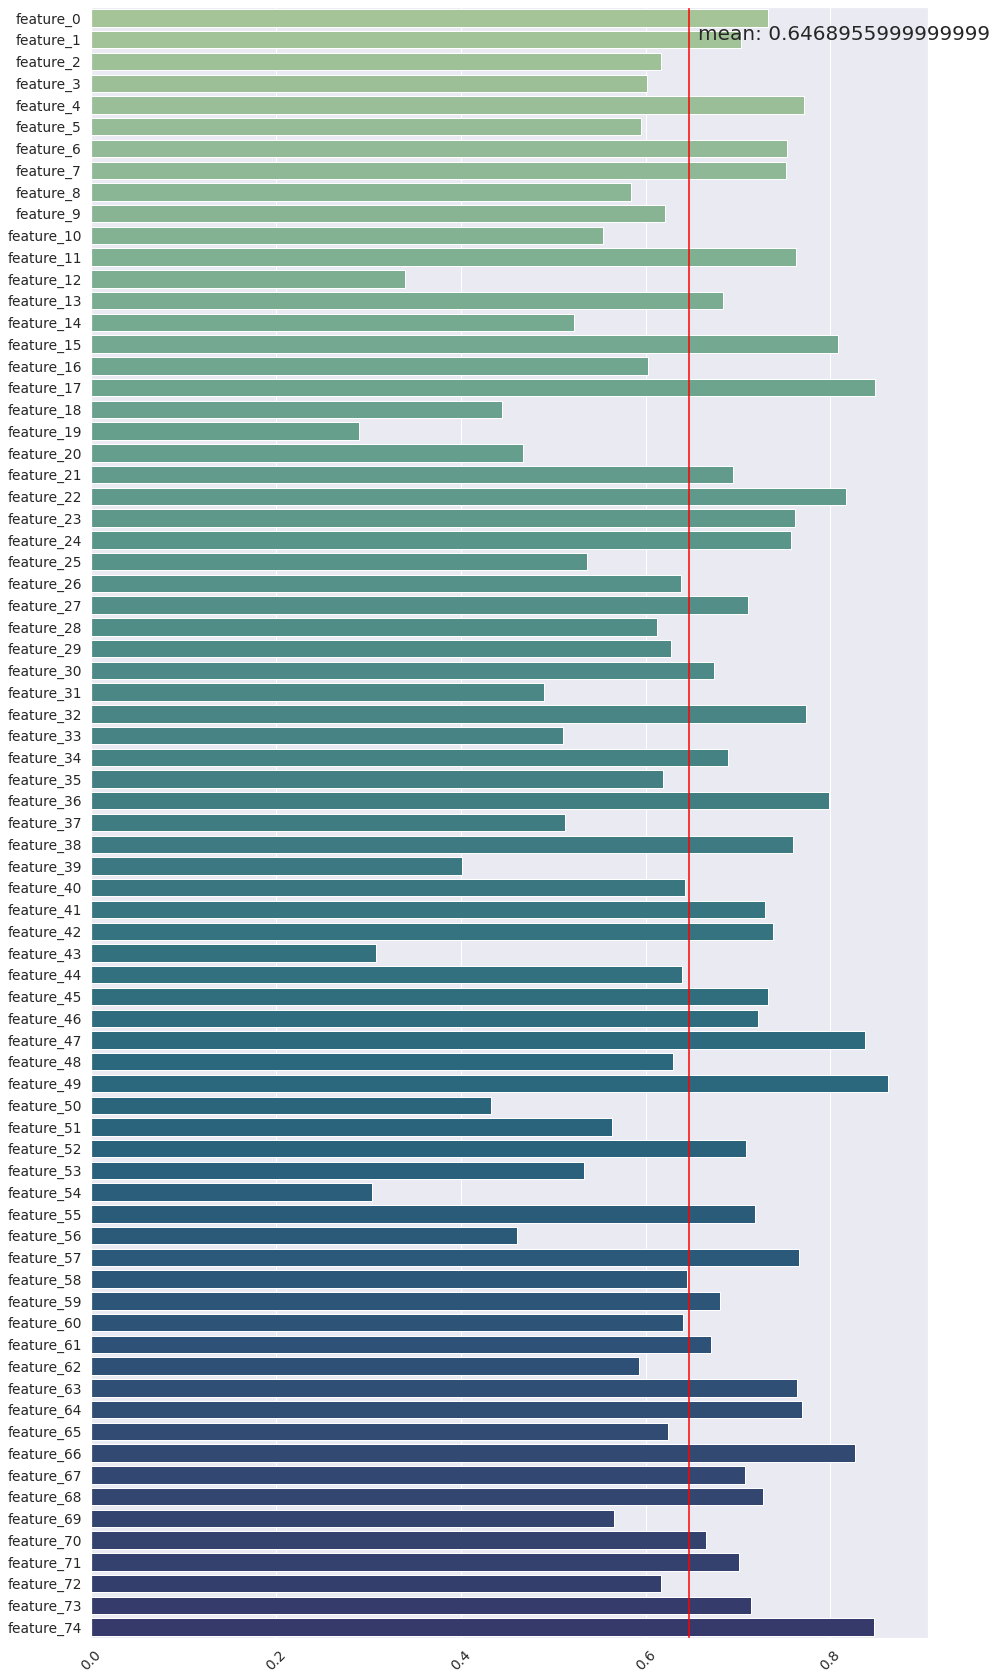

In [ ]:
fig, zero_train = plt.subplots(figsize = (15,30))
plt.xticks(rotation=45)
zero_test = sns.barplot(data = pd.DataFrame((test[x_cols]==0).mean()).T, palette="crest", orient='h')

zero_test.axvline((test[x_cols]==0).mean().mean(), color ='red')
zero_test.text((test[x_cols]==0).mean().mean()+0.01, 1, "mean: {}".format((test[x_cols]==0).mean().mean()), size = 20, alpha = 1)
#fig.suptitle('Zero distribution in TRAIN dataset', fontsize = 25, fontweight = 'bold')

**OUTLIERS**

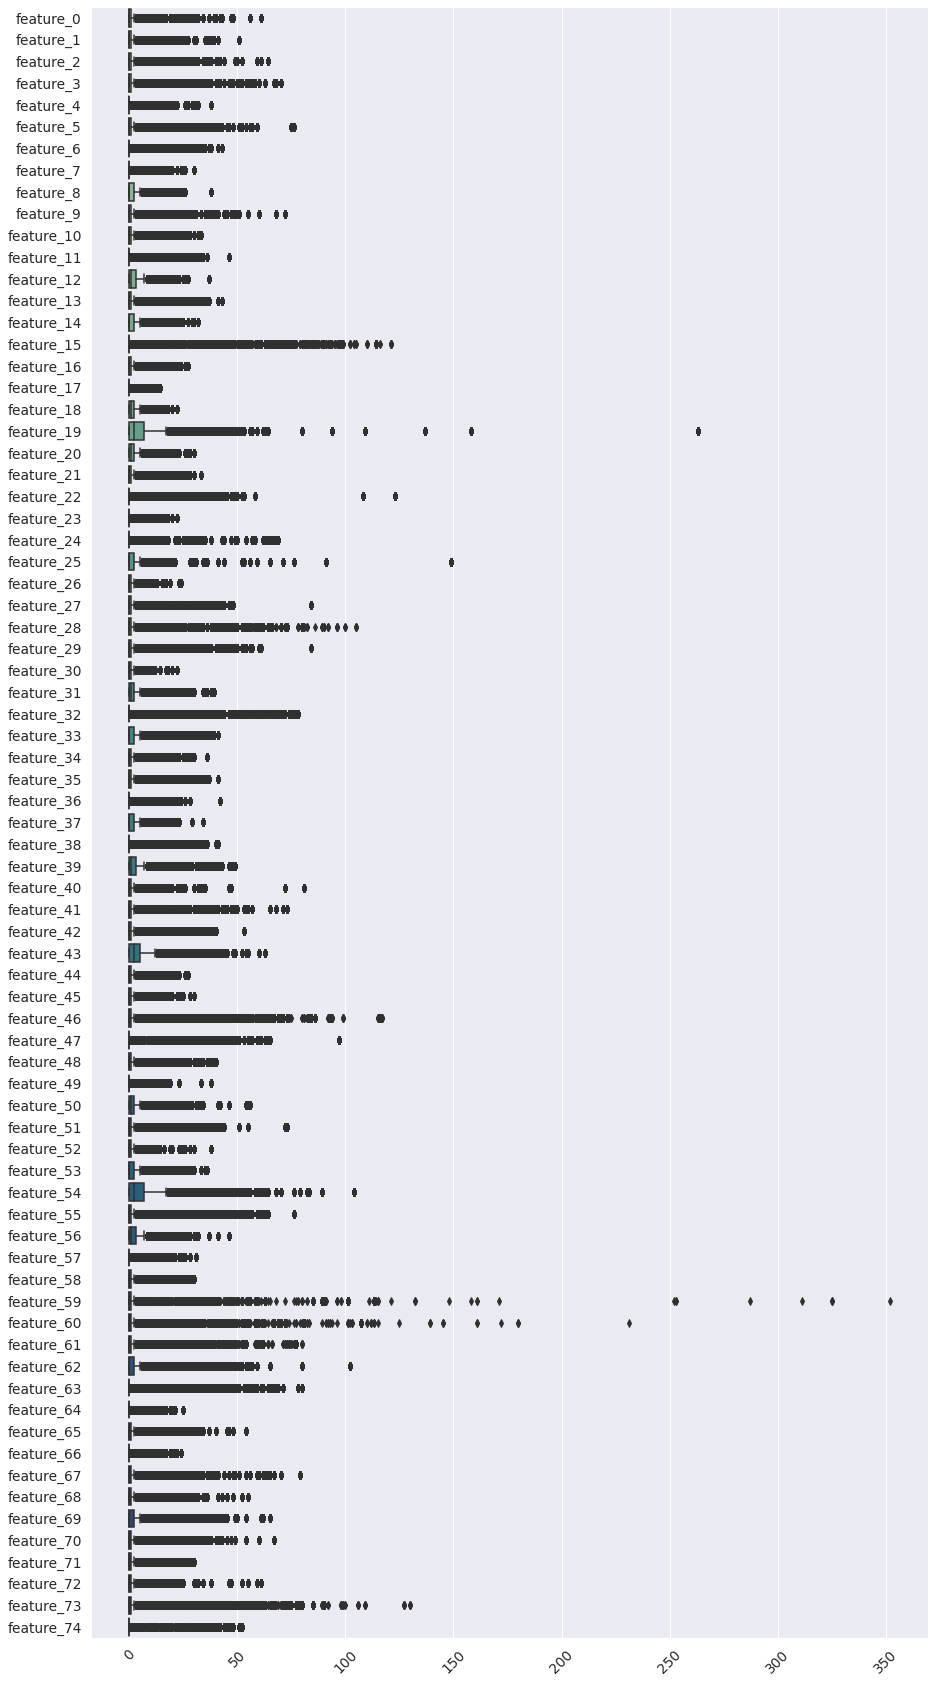

In [ ]:
fig, out_fig = plt.subplots(figsize = (15,30))
plt.xticks(rotation=45)
out_fig = sns.boxplot(data = train, orient="h", palette="crest")

**DIMENTIONALITY REDUCTION**

**TSNE**

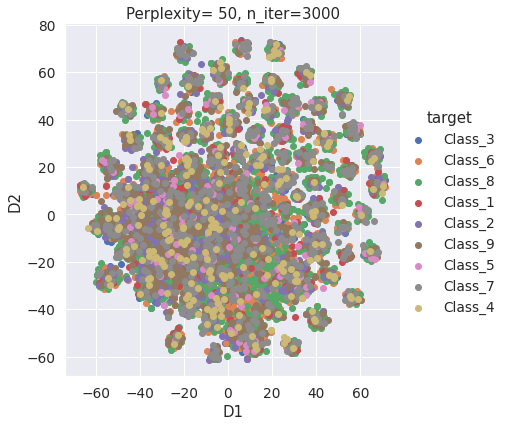

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

train_sub = train.sample(10000, random_state= 42)
model = TSNE(n_components=2, random_state=0, perplexity= 50, n_iter=3000)
tsne_data = model.fit_transform(StandardScaler().fit_transform(train_sub.drop('target', axis = 1).astype(float)))
tsne_data = np.vstack((tsne_data.T, train_sub.target)).T

tsne_df = pd.DataFrame(data=tsne_data, columns=("D1", "D2", "target"))

sns.FacetGrid(tsne_df, hue="target", height=6).map(plt.scatter, 'D1', 'D2').add_legend()
plt.title('Perplexity= 50, n_iter=3000')
plt.show()

**LDA**

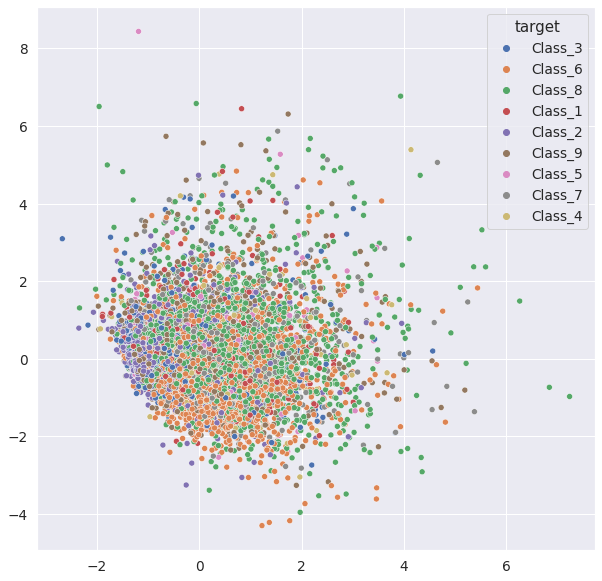

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

train_sub = train.sample(10000, random_state= 42)
lda_data = LDA(n_components=2).fit_transform(train_sub.drop(columns='target'),train_sub.target)
plt.figure(figsize=(10,10))
sns.scatterplot(x = lda_data[:, 0], y = lda_data[:, 1], hue = 'target', data=train_sub)

**UMAP**

In [ ]:
!pip install umap-learn

In [ ]:
import umap

train_sub = train.sample(10000, random_state= 42)
embedding_2d = umap.UMAP(random_state = 42 ,n_components=2).fit_transform(train_sub.drop(columns='target').to_numpy())
embedding_3d = umap.UMAP(random_state = 42 ,n_components=3).fit_transform(train_sub.drop(columns='target').to_numpy())

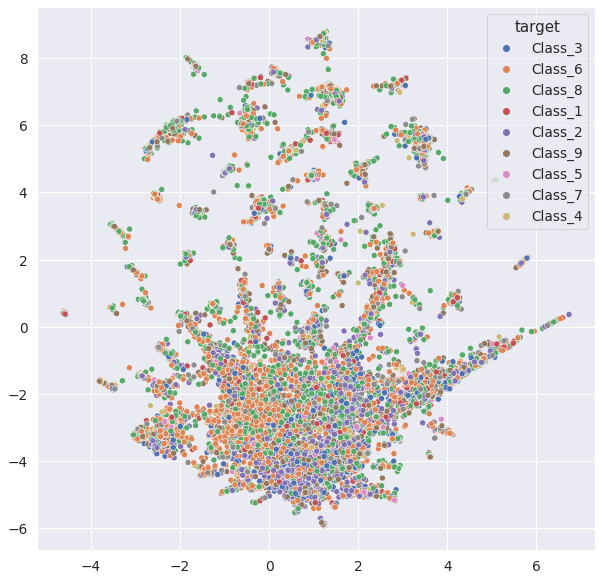

In [ ]:
plt.figure(figsize=(10,10))
sns.scatterplot(x = embedding_2d[:, 0], y = embedding_2d[:, 1], hue='target', data=train_sub)

**UMAP 3D**

In [ ]:
plt.figure(figsize=(50,30))
umap_3d = px.scatter_3d(
    embedding_3d, x=0, y=1, z=2,
    labels={'color': 'target'},
    color= train_sub.target,
    color_discrete_sequence=['red', 'seagreen', 'gold', 'black'],
)

umap_3d.update_traces(marker_size=2)
umap_3d.show()

<Figure size 3600x2160 with 0 Axes>

**AUTOML - MLJAR TRAINING**

How amazing is to run over 60 models and their combination writing only one line of code!!! This is really rapid development.



In [ ]:
OPTUNA = False

In [ ]:
if OPTUNA:
    automl = AutoML(
        mode="Optuna",
        optuna_time_budget=600,
        total_time_limit=6*3600,
        golden_features=True,
        boost_on_errors=True,
        optuna_verbose=False)
    
else:
     automl = AutoML(
        mode="Compete", 
        algorithms=["CatBoost", "Xgboost", "LightGBM"], # I check in one run that only these 3 gb tree algorithms play roles in this competition
        total_time_limit=3*3600)

## You can highly customize MLJAR experiments
'''
    automl = AutoML(
        mode = "Compete",
        algorithms=["CatBoost", "Xgboost", "LightGBM"],
        total_time_limit=4*3600,
        start_random_models=10,
        hill_climbing_steps=3,
        top_models_to_improve=3,
        golden_features=True,
        features_selection=True,
        stack_models=True,
        train_ensemble=True,
        explain_level=1,
        ml_task = 'multiclass_classification',
        eval_metric='logloss',
        validation_strategy={
            "validation_type": "kfold",
            "k_folds": 5,
            "shuffle": False,
            "stratify": True,
        })
'''

automl.fit(train[x_cols], train[y_col])

AutoML directory: AutoML_1
The task is multiclass_classification with evaluation metric logloss
AutoML will use algorithms: ['CatBoost', 'Xgboost', 'LightGBM']
AutoML will stack models
AutoML will ensemble availabe models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'kmeans_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'boost_on_errors', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree logloss 1.82877 trained in 3.97 seconds
Adjust validation. Remove: 1_DecisionTree
Validation strategy: 10-fold CV Shuffle,Stratify
Skip simple_algorithms because no parameters were generated.
* Step default_algorithms will try to check up to 3 models
1_Default_LightGBM logloss 1.752445 trained in 712.76 seconds


In [23]:
preds = automl.predict_proba(test)

sub = pd.read_csv("/content/sample_data/sample_submission.csv")
sub[sub.columns[1:]] = preds

sub.to_csv("MLJAR_submission.csv", index=False)

**LOOK INSIDE SUBMISSION FILE**

Text(0.5, 0.98, 'Class prediction distribution')

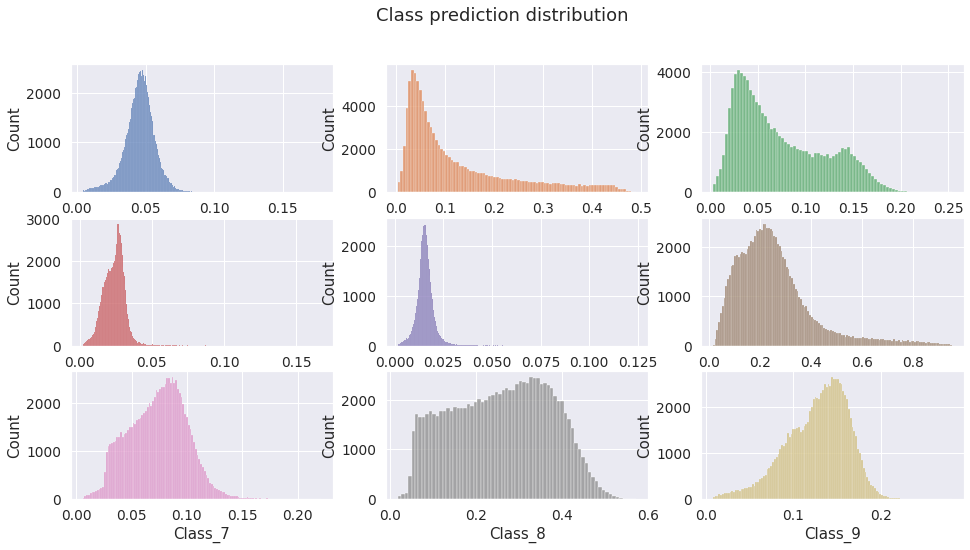

In [24]:
palette = itertools.cycle(sns.color_palette())

plt.figure(figsize=(16, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    c = next(palette)
    sns.histplot(sub, x = f'Class_{i+1}', color=c)
plt.suptitle("Class prediction distribution")


In [25]:
sub.drop("id", axis=1).describe().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

In [26]:
automl.report()